In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob

import string
import re

import spacy
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
print(stopWords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [3]:
df = pd.read_csv('./data/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# Data Preparation

In [4]:
df = df.drop(columns='Unnamed: 0')
df[['title', 'text']] = df[['title', 'text']].fillna(' ')
# Reverse labels into: fake=1, real=0
df['label'] = 1 - df['label']

In [5]:
df['title_text'] = df['title'] + ' ' + df['text']

df["text_word_count"] = df["text"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df["title_word_count"] = df["title"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

df["text_unique_words"] = df["text"].apply(lambda x: len(set(x.lower().split())) if pd.notnull(x) else 0)

df["text_char_count"] = df["text"].apply(lambda x: len(x) - x.count(' ') if pd.notnull(x) else 0)
df["title_char_count"] = df["title"].apply(lambda x: len(x) - x.count(' ') if pd.notnull(x) else 0)

In [6]:
# Function for calculating the average word length
def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# Function for calculating the number of sentences
def sentence_count(text):
    sentences = re.split(r'[.!?]', text)  # Sentence splitting for '.', '!', '?'
    sentences = [s for s in sentences if s.strip()]  # Removes empty sentences
    return len(sentences)

# Function for counting special characters
def special_char_count(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', text))  # Finds all special characters

# Applying the functions to the text column
df['avg_word_length'] = df['text'].apply(lambda x: avg_word_length(str(x)))
df['sentence_count'] = df['text'].apply(lambda x: sentence_count(str(x)))
df['special_char_count'] = df['text'].apply(lambda x: special_char_count(str(x)))

# Exploratory Data Analysis

In [7]:
print("First rows of the dataset:")
display(df.head(10))

print("\nGeneral informations:")
print(df.info())

print("\nNumber of missing values per column:")
print(df.isnull().sum())

print(f"\nNumber of whitespaces in title column: {df.text[df['title'] == ' '].count()}")
print(f"Number of whitespaces in text column: {df.text[df['text'] == ' '].count()}")

print(f"\nNumber of two whitespaces in title column: {df.text[df['title'] == '  '].count()}")
print(f"Number of two whitespaces in text column: {df.text[df['text'] == '  '].count()}")

print(f"\nTotal Number of columns text and title with only whitespaces: {df.text[(df['text'] == ' ') | (df['title'] == ' ')].count()}")
print(f"Anteil fehlende Werte in title & text column: {(df.text[(df['text'] == ' ') | (df['title'] == ' ')].count()) / len(df) * 100} %")

print(f'\nNumber of duplicates in title column: {df.title.duplicated().sum()}')
prop_fake_title = df[df.title.duplicated()]['label'].mean() * 100
print(f'Proportion of Fake news in duplications title column: {prop_fake_title:.2f} %')
print(f'Number of duplicates in text column: {df.text.duplicated().sum()}')
prop_fake_text = df[df.text.duplicated()]['label'].mean() * 100
print(f'Proportion of Fake news in duplications title column: {prop_fake_text:.2f} %')
print(f'Number of duplicate in title and text column: {(df.text.duplicated() & df.text.duplicated()).sum()}')
print(f'Proportion duplicates to all records: {((df.text.duplicated() & df.text.duplicated()).sum()) / len(df) *100} %')

print("\nStatistical overview of categorical features:")
display(df.describe(include='object'))

First rows of the dataset:


,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182
1,,Did they post their votes for Hillary already?,0,Did they post their votes for Hillary already?,8,0,8,39,0,4.875000,1,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,About Time! Christian Group Sues Amazon and SP...,244,13,153,1276,66,5.229508,13,41
6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,0,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,15,20,15,66,86,4.400000,2,2
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,0,12,0,0,68,0.000000,0,0
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",0,Sports Bar Owner Bans NFL Games…Will Show Only...,265,19,173,1170,98,4.415094,14,33
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",0,Latest Pipeline Leak Underscores Dangers Of Da...,485,9,308,2535,58,5.202062,28,122



General informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               72134 non-null  object 
 1   text                72134 non-null  object 
 2   label               72134 non-null  int64  
 3   title_text          72134 non-null  object 
 4   text_word_count     72134 non-null  int64  
 5   title_word_count    72134 non-null  int64  
 6   text_unique_words   72134 non-null  int64  
 7   text_char_count     72134 non-null  int64  
 8   title_char_count    72134 non-null  int64  
 9   avg_word_length     72134 non-null  float64
 10  sentence_count      72134 non-null  int64  
 11  special_char_count  72134 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 6.6+ MB
None

Number of missing values per column:
title                 0
text                  0
label                 0
title

,title,text,title_text
count,72134,72134,72134
unique,62348,62718,63678
top,,,Highlights: The Trump presidency on April 13 a...
freq,558,777,8


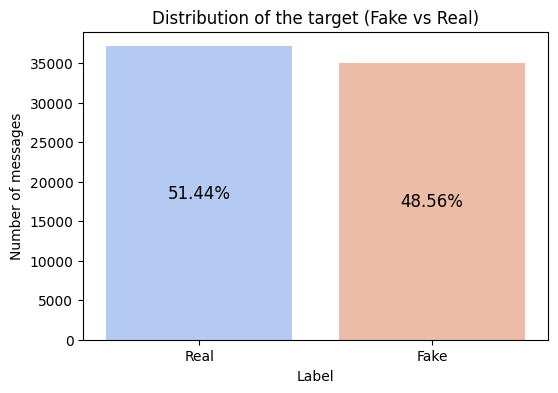

In [8]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Distribution of the target (Fake vs Real)')
ax.set_xticklabels(['Real', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Number of messages')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    # percentage = f'{df.label.mean() * 100:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
    
plt.show()

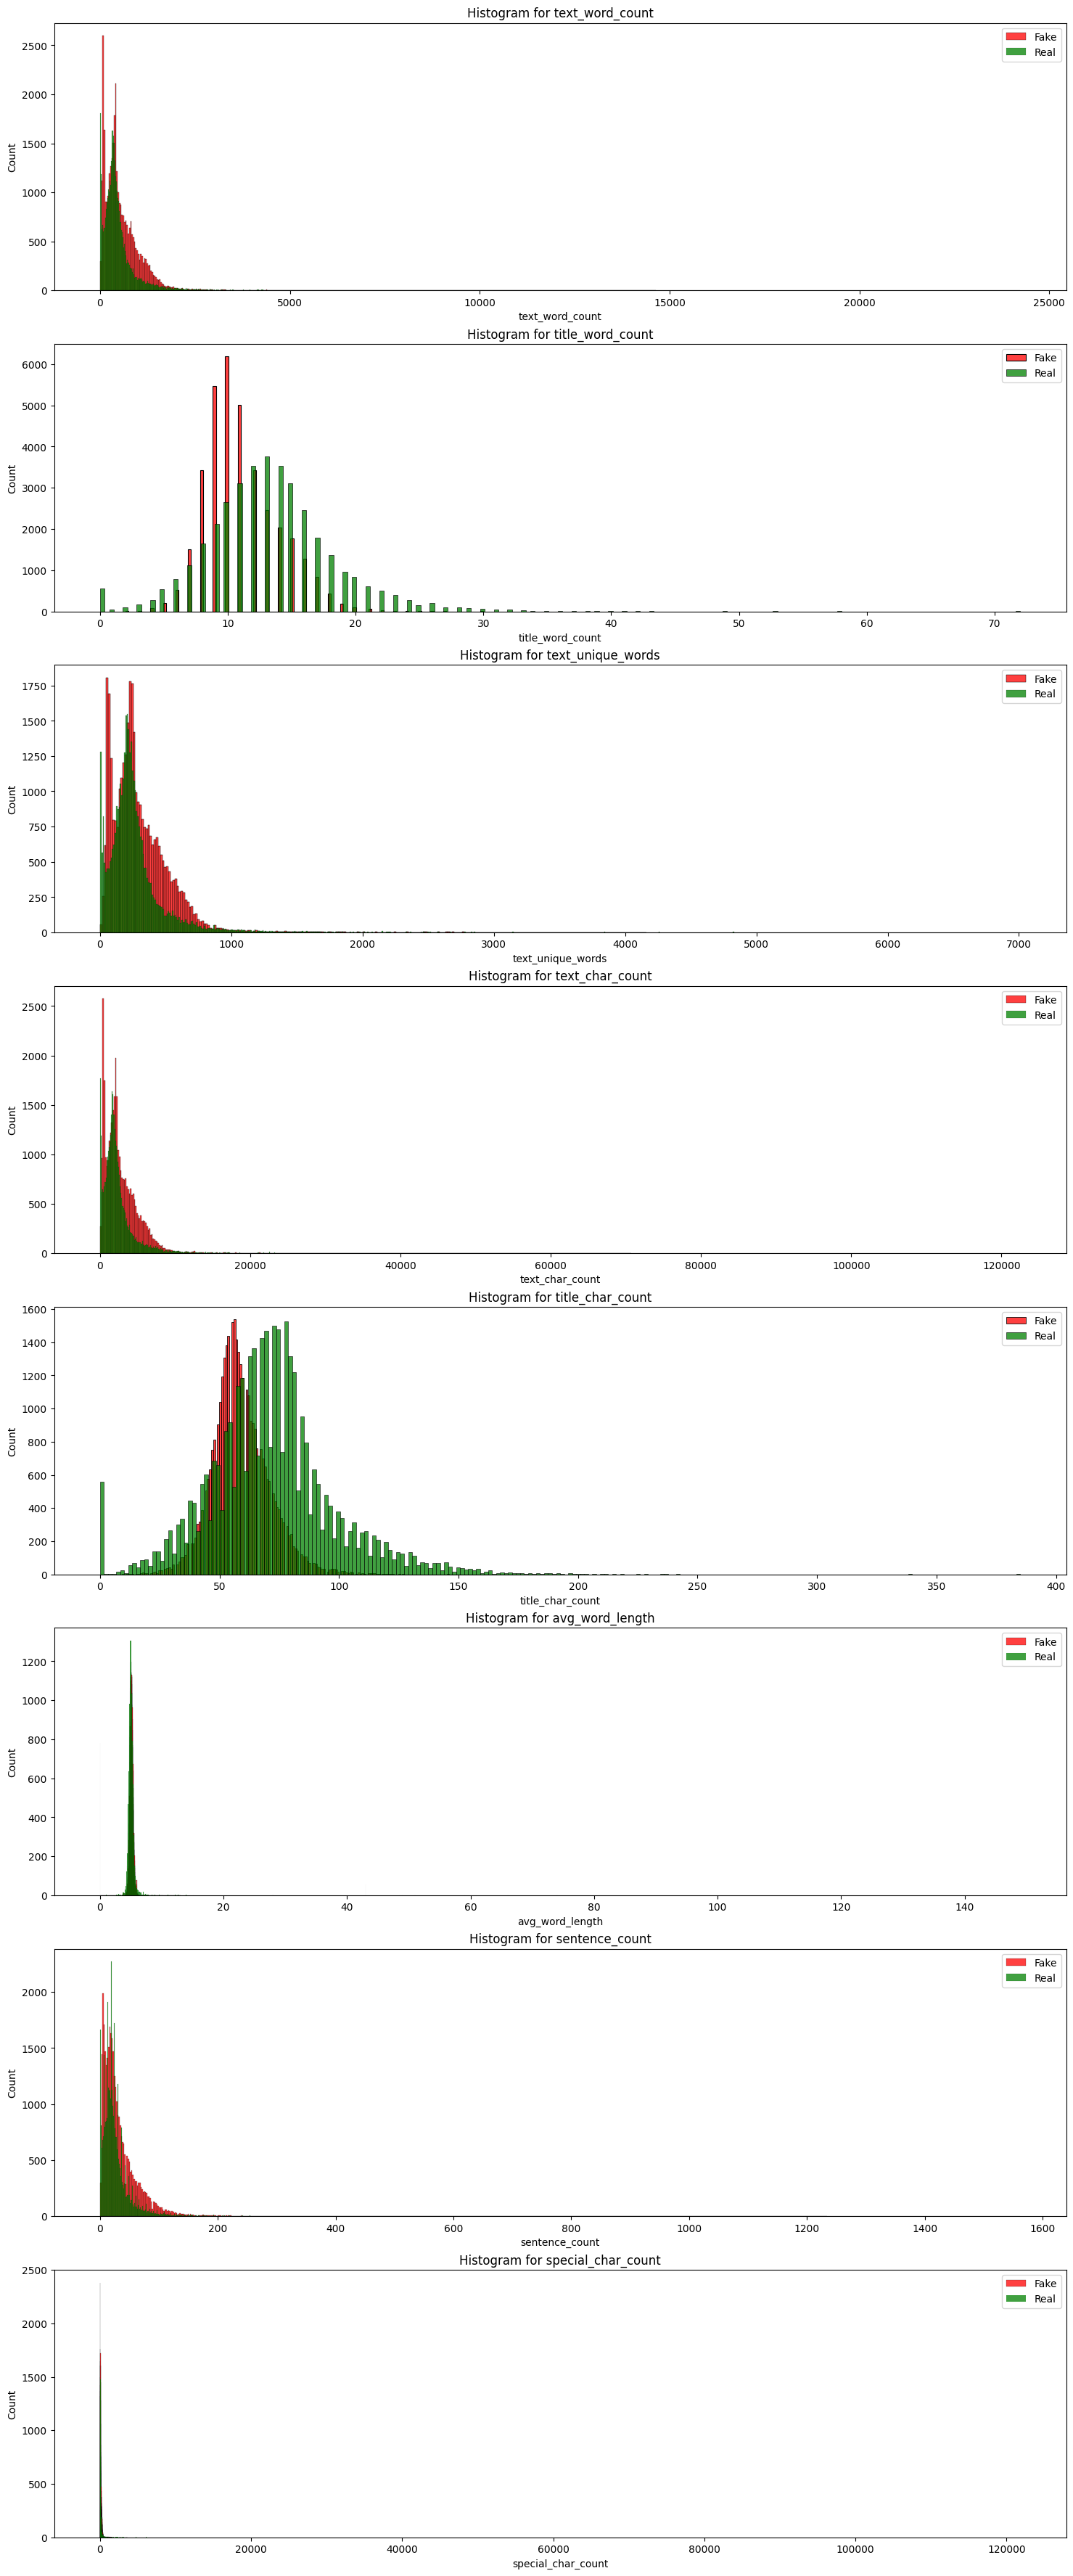

In [9]:
# Checking distributions
fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(18, 45))

# Define columns to plot
columns = df.select_dtypes(include=['number']).columns.drop('label')

# Plotting histplots for each column
for i, col in enumerate(columns):
    sns.histplot(df[col][df.label == 1], color="red", ax=ax[i], label="Fake")
    sns.histplot(df[col][df.label == 0], color="green", ax=ax[i], label="Real")
    ax[i].set_title(f'Histogram for {col}')
    ax[i].legend()

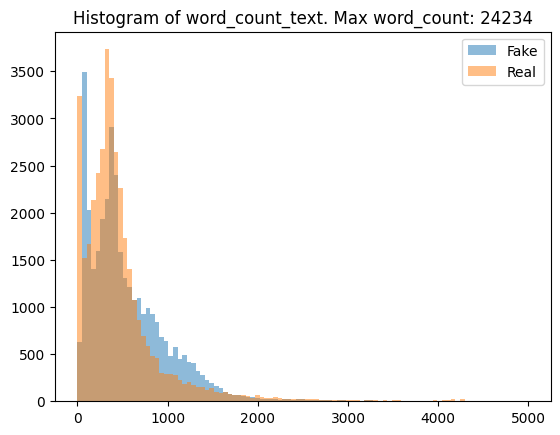

In [10]:
bins = np.linspace(0, 5000, 100)

plt.hist(df[df["label"]== 1]["text_word_count"], bins, alpha=0.5, label="Fake")
plt.hist(df[df["label"]== 0]["text_word_count"], bins, alpha=0.5, label="Real")
plt.title(f'Histogram of word_count_text. Max word_count: {df["text_word_count"].max()}')
plt.legend(loc="upper right")
plt.show()

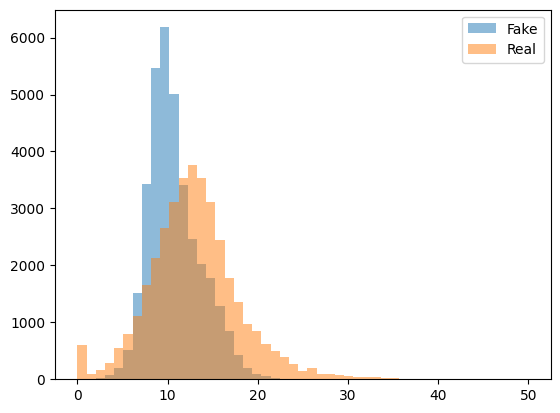

In [11]:
bins = np.linspace(0, 50, 50)

plt.hist(df[df["label"]== 1]["title_word_count"], bins, alpha=0.5, label="Fake")
plt.hist(df[df["label"]== 0]["title_word_count"], bins, alpha=0.5, label="Real")
plt.legend(loc="upper right")
plt.show()

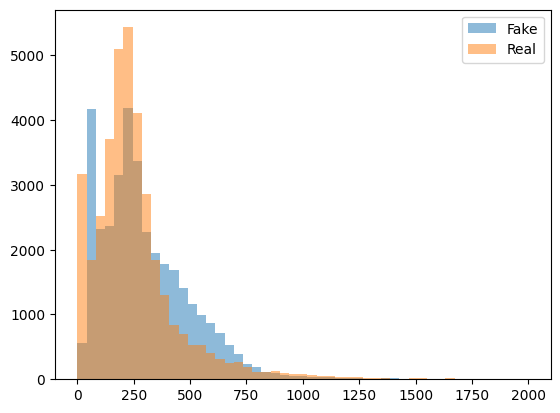

In [12]:
bins = np.linspace(0, 2000, 50)

plt.hist(df[df["label"]== 1]["text_unique_words"], bins, alpha=0.5, label="Fake")
plt.hist(df[df["label"]== 0]["text_unique_words"], bins, alpha=0.5, label="Real")
plt.legend(loc="upper right")
plt.show()

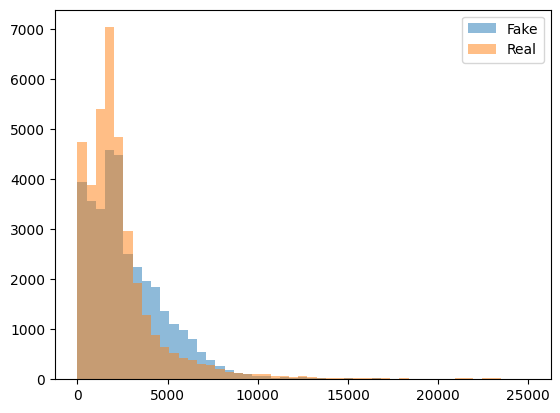

In [13]:
bins = np.linspace(0, 25000, 50)

plt.hist(df[df["label"]== 1]["text_char_count"], bins, alpha=0.5, label="Fake")
plt.hist(df[df["label"]== 0]["text_char_count"], bins, alpha=0.5, label="Real")
plt.legend(loc="upper right")
plt.show()

In [14]:
df[df.text.duplicated(keep=False)].sort_values(by='text', ascending=False).head(20)

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
21156,Rep. Gowdy on the impact of the FBI’s new Clin...,‹ › Debbie Menon is an independent writer base...,0,Rep. Gowdy on the impact of the FBI’s new Clin...,657,11,357,3407,47,5.176560,36,110
47449,Rep. Gowdy on the impact of the FBI’s new Clin...,‹ › Debbie Menon is an independent writer base...,0,Rep. Gowdy on the impact of the FBI’s new Clin...,657,11,357,3407,47,5.176560,36,110
41466,“Honor Our Immigrant Veterans” Replayed,‹ › Arnaldo Rodgers is a trained and educated ...,0,“Honor Our Immigrant Veterans” Replayed ‹ › Ar...,354,5,215,1665,35,4.689266,23,65
2960,“Honor Our Immigrant Veterans” Replayed,‹ › Arnaldo Rodgers is a trained and educated ...,0,“Honor Our Immigrant Veterans” Replayed ‹ › Ar...,354,5,215,1665,35,4.689266,23,65
6052,Veterans help veterans cope with PTSD through ...,‹ › Arnaldo Rodgers is a trained and educated ...,0,Veterans help veterans cope with PTSD through ...,260,14,184,1305,95,4.992308,15,53
16544,Veterans help veterans cope with PTSD through ...,‹ › Arnaldo Rodgers is a trained and educated ...,0,Veterans help veterans cope with PTSD through ...,260,14,184,1305,95,4.992308,15,53
53354,VA fails to properly examine thousands of vete...,‹ › Arnaldo Rodgers is a trained and educated ...,0,VA fails to properly examine thousands of vete...,268,8,178,1281,43,4.746269,17,51
26780,VA fails to properly examine thousands of vete...,‹ › Arnaldo Rodgers is a trained and educated ...,0,VA fails to properly examine thousands of vete...,268,8,178,1281,43,4.746269,17,51
37949,Spirit to thank veterans at annual Veterans Da...,‹ › Arnaldo Rodgers is a trained and educated ...,0,Spirit to thank veterans at annual Veterans Da...,252,9,154,1293,46,5.107143,20,43
22124,Spirit to thank veterans at annual Veterans Da...,‹ › Arnaldo Rodgers is a trained and educated ...,0,Spirit to thank veterans at annual Veterans Da...,252,9,154,1293,46,5.107143,20,43


In [15]:
df.sort_values(by='text', ascending= False).head(50)[['title', 'text', 'label']]

,title,text,label
11165,🚨Bill Clinton and Hillary Lolita Express Pedop...,🚨Bill Clinton and Hillary Lolita Express Pedop...,0
31816,,🙂,0
40405,俄罗斯总统观注,安理会28日会议2016年十月\n俄罗斯总统观注 伏尔泰网 | 纽约（美国） | 2016年...,0
59448,Press Secretary Affirms that Trump Believes Li...,■ White House press secretary Sean Spicer stoo...,1
61773,Trump National Security Adviser Called Russian...,■ The national security adviser appointed by ...,1
31998,Taxpayers Will Defend Trump in Suit Charging C...,■ The federal taxpayer will be defending Presi...,1
69156,White House Says Bathrobe Anecdote Is All Wet ...,"■ The White House press secretary, Sean Spicer...",1
19929,Senate Judiciary Committee Approves Gorsuch in...,"■ The Senate Judiciary Committee, in a vo...",1
9177,N.F.L.: Here’s What We Learned in Week 1 - The...,■ The Oakland Raiders defense may need some ti...,1
67956,Democrats and Feds in Dispute on Trump’s D.C. ...,■ The General Services Administration disputed...,1


In [16]:
df[['title', 'text', 'label', 'text_word_count']].sort_values(by='text_word_count', ascending=False).head(10)

,title,text,label,text_word_count
327,Re: The Hard Working American vs. The Governme...,The Hard Working American vs. The Government P...,0,24234
54433,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,0,20891
34523,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,0,20891
6445,Заседание Международного дискуссионного клуба ...,Заседание Международного дискуссионного клуба ...,0,20876
17557,Re: How Many People Will Have To Migrate Out O...,How Many People Will Have To Migrate Out Of Ca...,0,20084
71687,Re: 55 Reasons Why California Is The Worst Sta...,55 Reasons Why California Is The Worst State I...,0,17427
30636,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,0,17332
37058,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,0,17332
63829,Re: Why Is Obama Threatening Russia With World...,Why Is Obama Threatening Russia With World War...,0,17201
14398,Benny Morris’s Untenable Denial of the Ethnic ...,References The Debate \nIt started when Daniel...,0,15199


In [17]:
df[['title', 'text', 'label', 'text_word_count']][(df['text_word_count'] < 5) & (df['text_word_count'] > 0)].sort_values(by='text_word_count', ascending=False)

,title,text,label,text_word_count
1269,,That would be unconstitutional.,0,4
11065,(VIDEO) BRAVO! TV HOST SCORCHES OBAMA FOR HIS ...,I VE HAD IT!,0,4
10939,,joking that’s my mum,0,4
16037,LIVE FEED: WATCH IVANKA AND DONALD TRUMP LIVE ...,Watch the speeches live;,0,4
17701,,Generally Confusing Accounting Principles,0,4
...,...,...,...,...
70126,DEAR DEMOCRATS AND LIBERALS…Stop Complaining A...,Ouch!,0,1
71073,NEWT GINGRICH Punches Back At Democrats With M...,https://www.youtube.com/watch?v=PjeOoJyPNCk,0,1
71327,THE VIEW’S Whoopi Goldberg To Co-Host: “This I...,https://youtu.be/RTuxvWjH3a4,0,1
71379,,Ludicrous...,0,1


In [18]:
df[['title', 'text', 'label', 'title_word_count']].sort_values(by='title_word_count', ascending=False).head()

,title,text,label,title_word_count
37207,Roger Stone update on Stop the Steal exit poll...,\nRoger Stone: Hillary Plans to Steal Election...,0,72
44714,"Scott Bennett, Whistleblower, U.S. Army Terror...",Exposing the I.S.I.S. Lie: How President Obama...,0,58
71215,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",0,53
29935,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",0,53
29831,Our Landfill Economy: Want to make a quick pro...,0 Our Landfill Economy: Want to make a quick p...,0,49


In [19]:
df[['title', 'text', 'label', 'text_unique_words']][df['text_unique_words'] > 0].sort_values(by='text_unique_words', ascending=True).head(10)

,title,text,label,text_unique_words
35621,"“THANK YOU BABY”…YES, FEMINISTS WILL GO NUTS: ...",https://www.youtube.com/watch?v=9LNyx_DWzzA,0,1
35510,WATCH! TRUMP SUPPORTER “BIG JOE” Surrounded By...,https://www.youtube.com/watch?v=IPqrimR8GWw,0,1
185,,Cool,0,1
14832,SARA CARTER WAS RIGHT ABOUT SPYING ON TRUMP! “...,https://www.youtube.com/watch?v=Ws5ojb0PCCo,0,1
43629,REP PETER KING: “Intel Community Carrying Out ...,https://www.youtube.com/watch?feature=player_e...,0,1
33434,GOTCHA! CNN PANELIST Called Out For Lying Abou...,https://www.youtube.com/watch?v=ISm-p8e-D7I,0,1
45084,“F*ck Trump! F*ck White People!” LEFTY GOES NU...,https://www.youtube.com/watch?v=zZ7GrEItGoo,0,1
56566,TOMI LAHREN Blasts The Left For Attacking Trum...,https://www.youtube.com/watch?time_continue=1&...,0,1
48838,"RIP, Vine",Trending,0,1
2531,INSANITY! HARRY REID CLAIMS Putin And Comey Co...,https://www.youtube.com/watch?v=sWbYpIj7CQ8,0,1


In [20]:
df[(df['text_unique_words'] > 2000) & (df['label'] == 1)].count()

title                 50
text                  50
label                 50
title_text            50
text_word_count       50
title_word_count      50
text_unique_words     50
text_char_count       50
title_char_count      50
avg_word_length       50
sentence_count        50
special_char_count    50
dtype: int64

In [21]:
df[['title', 'text', 'label', 'text_char_count']].sort_values(by='text_char_count', ascending=False).head()

,title,text,label,text_char_count
6445,Заседание Международного дискуссионного клуба ...,Заседание Международного дискуссионного клуба ...,0,122490
327,Re: The Hard Working American vs. The Governme...,The Hard Working American vs. The Government P...,0,109973
17557,Re: How Many People Will Have To Migrate Out O...,How Many People Will Have To Migrate Out Of Ca...,0,94925
54433,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,0,94476
34523,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,0,94476


In [22]:
df[['title', 'text', 'label', 'title_char_count']].sort_values(by='title_char_count', ascending=False).head()

,title,text,label,title_char_count
37207,Roger Stone update on Stop the Steal exit poll...,\nRoger Stone: Hillary Plans to Steal Election...,0,385
44714,"Scott Bennett, Whistleblower, U.S. Army Terror...",Exposing the I.S.I.S. Lie: How President Obama...,0,339
17630,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...,Hillary Clinton s supporters were calling cert...,0,242
34857,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...,Hillary Clinton s supporters were calling cert...,0,242
44873,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...,Hillary Clinton s supporters were calling cert...,0,242


In [23]:
df[['title', 'text', 'label', 'avg_word_length']].sort_values(by='avg_word_length', ascending=False).head(10)

,title,text,label,avg_word_length
44862,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,0,149.000000
42774,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,0,145.000000
52702,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,0,88.000000
14238,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,74.000000
26286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,74.000000
8909,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,74.000000
40405,俄罗斯总统观注,安理会28日会议2016年十月\n俄罗斯总统观注 伏尔泰网 | 纽约（美国） | 2016年...,0,73.548387
43629,REP PETER KING: “Intel Community Carrying Out ...,https://www.youtube.com/watch?feature=player_e...,0,67.000000
27236,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,66.000000
68385,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,66.000000


In [24]:
df[df['text'].apply(lambda x: bool(re.search(r'https?://\S+', str(x))))]
df[df['title'].astype(str).str.match(r'^https?://\S+$')]

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
795,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,66,66,66.000000,4,12
8909,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,74,74,74.000000,4,12
14238,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,74,74,74.000000,4,12
18445,https://youtu.be/BFpFCy_b2SM,"July 24, 2016 Latest Radio Show",0,"https://youtu.be/BFpFCy_b2SM July 24, 2016 Lat...",6,1,6,26,28,4.333333,1,1
26286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,74,74,74.000000,4,12
27236,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,66,66,66.000000,4,12
42774,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,0,https://100percentfedup.com/served-roy-moore-v...,1,1,1,145,145,145.000000,2,19
44862,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,0,https://100percentfedup.com/12-yr-old-black-co...,1,1,1,149,149,149.000000,2,26
52702,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,0,https://100percentfedup.com/video-hillary-aske...,1,1,1,88,88,88.000000,2,17
68385,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,66,66,66.000000,4,12


In [25]:
df.loc[44862, 'text']

'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/'

In [26]:
df[['title', 'text', 'label', 'special_char_count']].sort_values(by='special_char_count', ascending=False).head(50)

,title,text,label,special_char_count
6445,Заседание Международного дискуссионного клуба ...,Заседание Международного дискуссионного клуба ...,0,121808
6788,"Две цивилизации: Борьба не на жизнь, а на смерть?","Мир Антироссийская истерия, развернутая на Зап...",0,11760
54714,Скандал вокруг Пак Кын Хе – специальный прокур...,Страна: Южная Корея Мы продолжаем информироват...,0,9638
14317,Выкинуть хлам и жить по фэншуй,Общество » Практика » Как отдохнуть Как измени...,0,9381
52402,"""Собрал наглость в кулак и назвался писателем""",Общество » Практика » Как заработать В советск...,0,8912
19482,Концепция записка российского председательства,Заседание Совета Безопасности от 28 октября 20...,0,8157
29822,"Мэр Монпелье: «Пусть Путину не рады в Париже, ...",Премьер-министр России Дмитрий Медведев на зас...,0,7515
66143,Скандал вокруг Пак Кын Хе и Чхве Сун Силь – да...,Страна: Южная Корея Главным событием последней...,0,7465
61681,Fed Up Republicans Threaten Third Party Optio...,I ve been saying for a long time now that the ...,0,7295
50871,США и их союзники в поисках новых мер давления...,Страна: КНДР Пока обсуждение в ООН сирийских п...,0,7103


In [27]:
df.describe()

,label,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
count,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000
mean,0.485596,540.550933,12.173316,283.921410,2719.158233,65.231555,5.060669,30.531885,97.637647
std,0.499796,625.399748,4.255615,238.942487,3102.965371,21.921910,1.807620,38.269152,496.170294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,227.000000,9.000000,147.000000,1144.000000,53.000000,4.833861,12.000000,32.000000
50%,0.000000,398.000000,12.000000,234.000000,2017.000000,62.000000,5.038491,21.000000,59.000000
75%,1.000000,667.000000,14.000000,358.000000,3377.000000,75.000000,5.242921,37.000000,110.000000
max,1.000000,24234.000000,72.000000,7009.000000,122490.000000,385.000000,149.000000,1562.000000,121808.000000


label                 1.000000
sentence_count        0.083335
text_unique_words     0.080442
text_char_count       0.058763
text_word_count       0.057582
avg_word_length       0.018049
special_char_count    0.004179
title_word_count     -0.257237
title_char_count     -0.287657
Name: label, dtype: float64

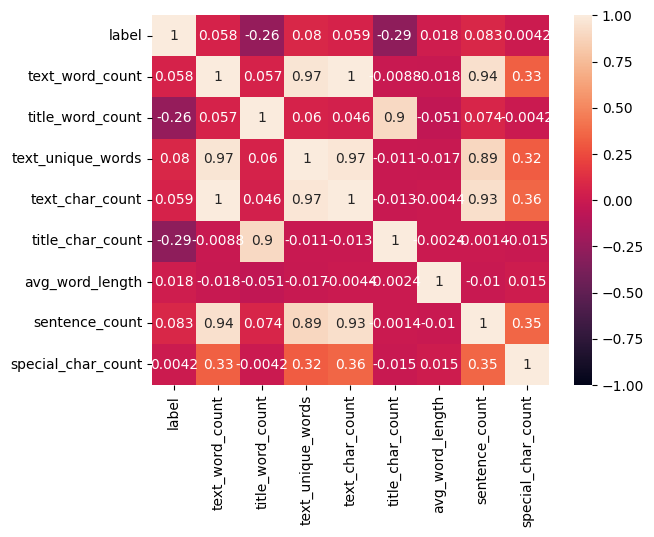

In [28]:
# visualize correlation matrix for numerical variables
df_corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True);

df_corr['label'].sort_values(ascending = False)

In [48]:
# import langid

# df['language'] = df['text'].astype(str).apply(lambda x: langid.classify(x)[0])

In [49]:
# df['language'] = df['text'].astype(str).apply(lambda x: TextBlob(x).detect_language())

In [50]:
# from langdetect import detect, DetectorFactory

# Fixiert die Zufälligkeit für reproduzierbare Ergebnisse
# DetectorFactory.seed = 42  

# Funktion zur Spracherkennung
# def detect_language(text):
    # try:
        # return detect(text)  # Gibt Sprachcode zurück (z. B. 'en', 'de', 'fr')
    # except:
        # return "unknown"  # Falls Erkennung fehlschlägt

# Spracherkennung auf die Textspalte anwenden
# df['language'] = df['text'].astype(str).apply(detect_language)

# Zeilen filtern, die nicht Englisch sind
# df_non_english = df[df['language'] != 'en']

# Ausgabe der nicht-englischen Texte
# print(df_non_english[['text', 'language']])


In [ ]:
text = ' '.join(title for title in df['text'])

# all_text = ' '.join(df['text'].dropna())
# wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(all_text)

wordcloud = WordCloud(
    stopwords=stopWords,
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=100
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [ ]:
text = ' '.join(title for title in df['title_text'])

# Erstellen der Wordcloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=100
).generate(text)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [37]:
fake_news = df[df['label'] == 1]
real_news = df[df['label'] == 0]
fake_texts = ' '.join(text for text in fake_news['title_text'])
real_texts = ' '.join(text for text in real_news['title_text'])

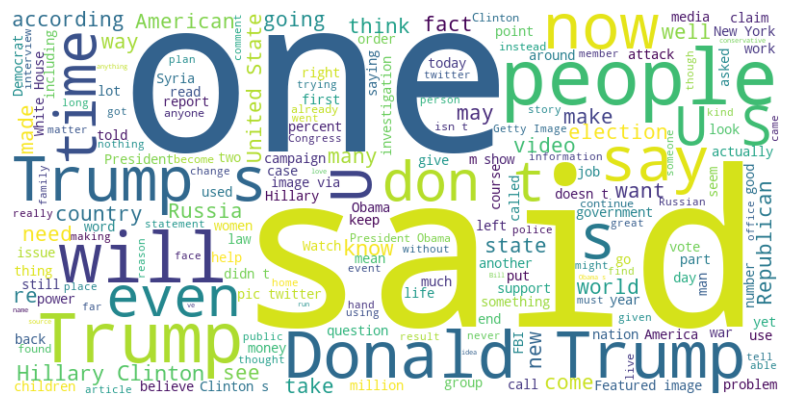

In [38]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200
).generate(fake_texts)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

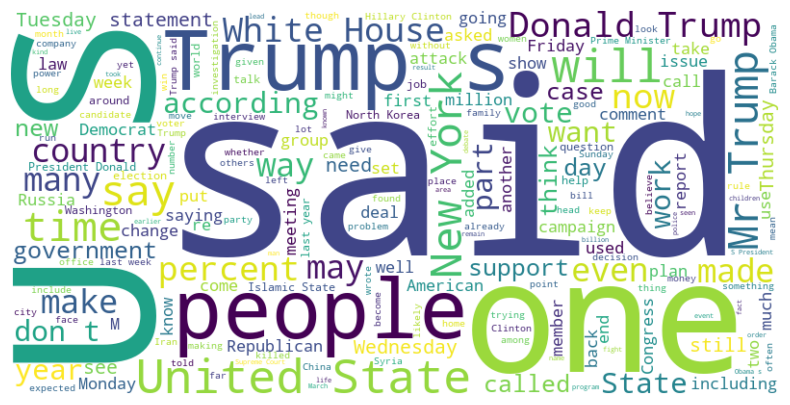

In [39]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200
).generate(real_texts)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [7]:
# 3.3 Most common words without stopwords

def get_most_common_words(texts, n=20):
    words = ' '.join(texts).split()
    filtered_words = [word.lower() for word in words if word.lower() not in stopWords and word.isalpha()]
    most_common = Counter(filtered_words).most_common(n)
    return pd.DataFrame(most_common, columns=['Word', 'Frequency'])

most_common_words = get_most_common_words(df['text'].dropna(), n=20)
print("\nMost common words (without stopwords):")
print(most_common_words)


Häufigste Wörter (ohne Stoppwörter):
          Word  Frequency
0         said     153964
1        trump     153926
2        would     104301
3          one      78176
4       people      73215
5    president      71183
6          new      68693
7         also      63367
8         like      52277
9      clinton      52074
10       could      49194
11       state      47568
12        even      42154
13      united      41970
14         two      40953
15      donald      40875
16        many      40132
17        last      39336
18  government      39103
19       obama      38027


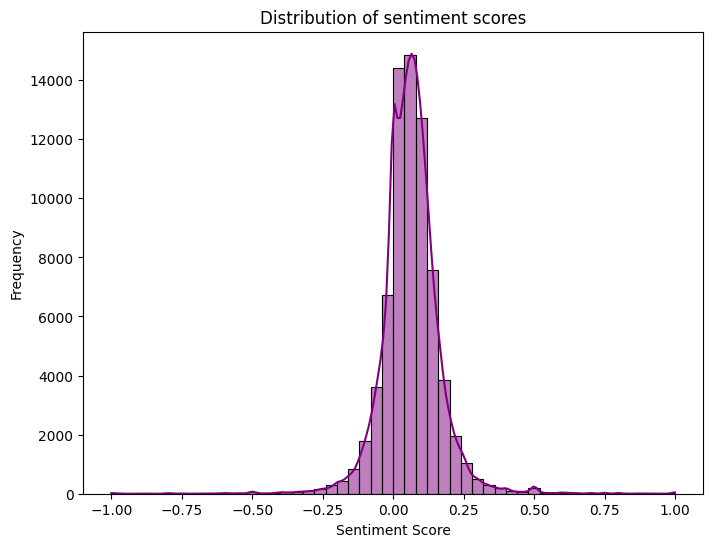

In [8]:
# 4. Sentiment Analysis

def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=50, kde=True, color='purple')
plt.title('Distribution of sentiment scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Findings

EDA abgeschlossen. Wichtige Erkenntnisse:

* Die Zielvariable ist ausgewogen verteilt. Allerdings wurden das Datenset aus verschiedenen Quellen zusammengetragen und scheint bereits resampled worden zu sein.
* Die Spalte Text enthält 1.335 fehlende Werte (1,9%)
* Das Datenset enthält 9.786 Duplikate (13%) --> Duplikate entfernen?
* Neue numerische features wurden generiert: 'title', 'text', 'label', 'title_text', 'text_word_count', 'title_word_count', 'text_unique_words', 'text_char_count', 'title_char_count', 'avg_word_length', 'sentence_count', 'special_char_count'
* Textlängen variieren stark.
* Alle numerischen features weisen ungewöhnliche Werte und potentielle Ausreißer auf
* Es gibt Einträge, die nur ein Wort enthalten
* Es gibt Einträge, die nur eine Webadresse enthalten
* Das Datenset enthält Texte in nciht englsicher Sprache
* Einige Texte fangen mit \n an
* Smileys etc. enthalten
* Wordcloud und häufigste Wörter geben erste Hinweise auf häufige Begriffe.

In [10]:
from spacy.lang.en.examples import sentences
nlp = spacy.load('en_core_web_sm')
type(nlp)

spacy.lang.en.English

In [11]:
# save punctuations and print them
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [12]:
# `text_cleaner` function
def text_cleaner(sentence):
    """Clean the text using typical NLP-Steps.
 
    Steps include: Lemmatization, removing stop words, removing punctuations 
 
    Args:
        sentence (str): The uncleaned text.
 
    Returns:
        str: The cleaned text.
        
    """

    # Create the Doc object named `text` from `sentence` using `nlp()`
    doc = nlp(sentence)
    # Lemmatization
    lemma_token = [token.lemma_ for token in doc if token.pos_ != 'PRON']
    # Remove stop words and converting tokens to lowercase
    no_stopWords_lemma_token = [token.lower() for token in lemma_token if token not in stopWords]
    # Remove punctuations
    clean_doc = [token for token in no_stopWords_lemma_token if token not in punctuations]
    # Use the `.join` method on `text` to convert string
    joined_clean_doc = " ".join(clean_doc)
    # Use `re.sub()` to substitute multiple spaces or dots`[\.\s]+` to single space `' '
    final_doc = re.sub('[\.\s]+', ' ', joined_clean_doc)
    return final_doc

In [52]:
df_sample = df.sample(n=50, replace=False, random_state=42)
df_sample.head()

,title,text,label,title_text,word_len
14191,Pence Will Speak at Anti-Abortion Rally - The ...,WASHINGTON — Vice President Mike Pence will...,0,Pence Will Speak at Anti-Abortion Rally - The ...,1514
24982,Trump Claims That Optimism In America Is ‘Gre...,Donald Trump keeps pretending that everyone is...,1,Trump Claims That Optimism In America Is ‘Gre...,2586
32032,Congressman proposes ban on Trump hotels use b...,WASHINGTON (Reuters) - A Democratic member of ...,0,Congressman proposes ban on Trump hotels use b...,827
68890,Factbox: Trump on Twitter (April 19) - Georgia...,The following statements were posted to the ve...,0,Factbox: Trump on Twitter (April 19) - Georgia...,637
55416,"Elites: ’Davos Always Wrong’, Globalism Push F...","The political and business elite, who attend t...",0,"Elites: ’Davos Always Wrong’, Globalism Push F...",3274


In [53]:
df_sample['title_text_clean'] = df_sample['title_text'].apply(text_cleaner)

In [54]:
df_sample.head()

,title,text,label,title_text,word_len,title_text_clean
14191,Pence Will Speak at Anti-Abortion Rally - The ...,WASHINGTON — Vice President Mike Pence will...,0,Pence Will Speak at Anti-Abortion Rally - The ...,1514,penny speak anti abortion rally new york times...
24982,Trump Claims That Optimism In America Is ‘Gre...,Donald Trump keeps pretending that everyone is...,1,Trump Claims That Optimism In America Is ‘Gre...,2586,trump claims optimism america great ’s make w...
32032,Congressman proposes ban on Trump hotels use b...,WASHINGTON (Reuters) - A Democratic member of ...,0,Congressman proposes ban on Trump hotels use b...,827,congressman propose ban trump hotel use u s go...
68890,Factbox: Trump on Twitter (April 19) - Georgia...,The following statements were posted to the ve...,0,Factbox: Trump on Twitter (April 19) - Georgia...,637,factbox trump twitter april 19 georgia electio...
55416,"Elites: ’Davos Always Wrong’, Globalism Push F...","The political and business elite, who attend t...",0,"Elites: ’Davos Always Wrong’, Globalism Push F...",3274,elite davos always wrong globalism push fuelle...


In [13]:
# Apply text_cleaner
from tqdm import tqdm

# Fortschrittsanzeige außerhalb von Pandas
results = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Fortschritt"):
    results.append(text_cleaner(row['title_text']))

df['title_text_clean'] = results

df.head()

Fortschritt: 100%|████████████████████| 72134/72134 [1:42:39<00:00, 11.71it/s]


,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,0.033103,law enforcement high alert follow threats cops...
1,,Did they post their votes for Hillary already?,0,Did they post their votes for Hillary already?,8,0,8,39,0,4.875000,1,1,0.000000,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,0.258929,unbelievable obama ’s attorney general say mos...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,0.113865,bobby jindal raise hindu use story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,0.056373,satan 2 russia unveli image terrifying new sup...


In [3]:
path = './data/Dataset_cleaned.csv'

In [14]:
with open(path, 'w', encoding='utf-8', newline='') as file:
    df.to_csv(file, index=False)

print(f"CSV file was successfully saved under: {path}")

CSV file was successfully saved under: ./data/Dataset_cleaned.csv


In [4]:
with open(path, 'r', encoding='utf-8') as file:
    df_cleaned = pd.read_csv(file)

df_cleaned.head()

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,0.033103,law enforcement high alert follow threats cops...
1,,Did they post their votes for Hillary already?,0,Did they post their votes for Hillary already?,8,0,8,39,0,4.875000,1,1,0.000000,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,0.258929,unbelievable obama ’s attorney general say mos...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,0.113865,bobby jindal raise hindu use story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,0.056373,satan 2 russia unveli image terrifying new sup...


In [5]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['title', 'text', 'label', 'title_text'])
y = df_cleaned.loc[:, 'label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [8]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import Pipeline

# num_cols = df_cleaned.select_dtypes(include=['number']).columns.drop('label')
# text_col = 'title_text_clean'

# reprocessor = ColumnTransformer([
#     ('num', StandardScaler(), num_cols),
#     ('text', CountVectorizer(), text_col)
# ])

# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

# print(X_train.toarray())

In [6]:
X_train.head()

,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
60480,637,12,375,3295,69,5.172684,39,100,0.047439,media go nuts trump tweets hilarious video sho...
61738,461,10,268,2399,49,5.203905,26,63,-0.055842,poll find white republicans angry nearly time...
30459,118,6,88,599,44,5.076271,5,11,0.020536,germany call may 's brexit speech disappointin...
55435,147,11,116,771,50,5.231293,16,65,0.110204,factbox trump twitter oct 20 tax cut united ki...
14350,420,16,245,2148,84,5.083333,29,95,-0.126901,trump campaign say hillary supporter try assas...


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_bow = count_vectorizer.transform(X_test['title_text_clean'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['title_text_clean'])

In [8]:
print(f"X_train_bow Shape: {X_train_bow.shape}")  
print(f"y_train Shape: {y_train.shape}")

X_train_bow Shape: (50493, 193752)
y_train Shape: (50493,)


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier_bow = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_bow.fit(X_train_bow, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)

              precision    recall  f1-score   support

        Real       0.86      0.92      0.89     11028
        Fake       0.91      0.85      0.88     10613

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



<Axes: >

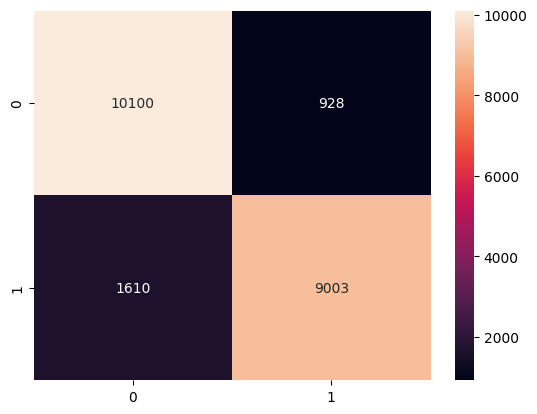

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_pred_rf = rf_classifier_bow.predict(X_test_bow)
print(classification_report(y_test, y_test_pred_rf, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test, y_test_pred_rf)

sns.heatmap(cm, annot=True, fmt='d')

In [13]:
rf_classifier_tfidf = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=0)

              precision    recall  f1-score   support

        Real       0.88      0.91      0.90     11028
        Fake       0.91      0.87      0.89     10613

    accuracy                           0.89     21641
   macro avg       0.90      0.89      0.89     21641
weighted avg       0.89      0.89      0.89     21641



<Axes: >

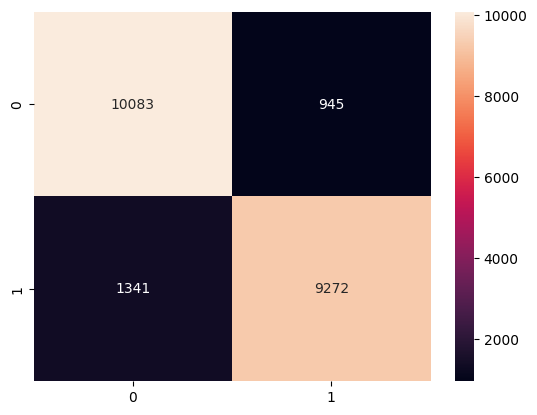

In [14]:
y_test_pred_rf_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred_rf_tfidf, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_test_pred_rf_tfidf)

sns.heatmap(cm, annot=True, fmt='d')

In [18]:
print(df_cleaned.shape)
df_no_duplicates = df_cleaned.drop_duplicates(subset=['title', 'text'])
df_no_duplicates.shape

(72134, 14)


(63678, 14)

In [21]:
X_no_dupl = df_no_duplicates.drop(columns=['title', 'text', 'label', 'title_text'])
y_no_dupl = df_no_duplicates.loc[:, 'label']

X_train_no_dupl, X_test_no_dupl, y_train_no_dupl, y_test_no_dupl = train_test_split(X_no_dupl, 
                                                    y_no_dupl, 
                                                    test_size=0.3, 
                                                    random_state=42)

count_vectorizer = CountVectorizer()
X_train_bow_np = count_vectorizer.fit_transform(X_train_no_dupl['title_text_clean'])
X_test_bow_np = count_vectorizer.transform(X_test_no_dupl['title_text_clean'])

              precision    recall  f1-score   support

        Real       0.85      0.89      0.87      8588
        Fake       0.91      0.87      0.89     10516

    accuracy                           0.88     19104
   macro avg       0.88      0.88      0.88     19104
weighted avg       0.88      0.88      0.88     19104



<Axes: >

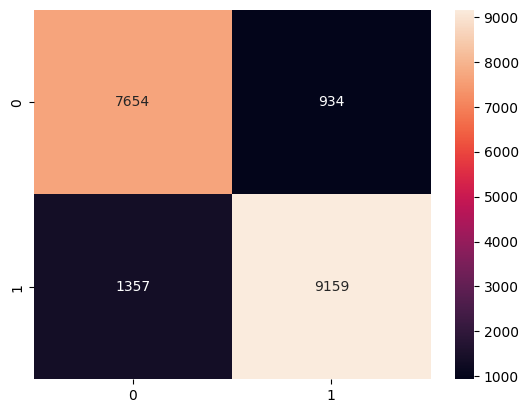

In [25]:
rf_classifier_bow_np = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)
rf_classifier_bow_np.fit(X_train_bow_np, y_train_no_dupl)

y_test_pred_rf_np = rf_classifier_bow_np.predict(X_test_bow_np)
print(classification_report(y_test_no_dupl, y_test_pred_rf_np, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test_no_dupl, y_test_pred_rf_np)

sns.heatmap(cm, annot=True, fmt='d')